In [1]:
# !unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/infected/
   creating: dataset/test/infected/covid/
  inflating: dataset/test/infected/covid/0.jpg  
  inflating: dataset/test/infected/covid/1.jpg  
  inflating: dataset/test/infected/covid/10.jpg  
  inflating: dataset/test/infected/covid/100.jpg  
  inflating: dataset/test/infected/covid/101.jpg  
  inflating: dataset/test/infected/covid/102.jpg  
  inflating: dataset/test/infected/covid/103.jpg  
  inflating: dataset/test/infected/covid/104.jpg  
  inflating: dataset/test/infected/covid/105.jpg  
  inflating: dataset/test/infected/covid/106.jpg  
  inflating: dataset/test/infected/covid/107.jpg  
  inflating: dataset/test/infected/covid/108.jpg  
  inflating: dataset/test/infected/covid/109.jpg  
  inflating: dataset/test/infected/covid/11.jpg  
  inflating: dataset/test/infected/covid/110.jpg  
  inflating: dataset/test/infected/covid/111.jpg  
  inflating: dataset/test/infected/covid/

# Cascading Binary Classification

In [2]:
import os
# Pandas and seaborn for plotting loss graphs
import pandas as pd
import seaborn as sns
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# Numpy
import numpy as np
# Pillow
from PIL import Image, ImageOps
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, BCELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torchvision
from torch.optim import Adam, SGD
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
dataset_paths = {'train_normal': './dataset/train/normal/',\
                 'train_infected_covid': './dataset/train/infected/covid/',\
                 'train_infected_non_covid': './dataset/train/infected/non-covid/',\
                 'val_normal': './dataset/val/normal/',\
                 'val_infected_covid': './dataset/val/infected/covid/',\
                 'val_infected_non_covid': './dataset/val/infected/non-covid/',\
                 'test_normal': './dataset/test/normal/',\
                 'test_infected_covid': './dataset/test/infected/covid/',\
                 'test_infected_non_covid': './dataset/test/infected/non-covid/'}
print(dataset_paths)

{'train_normal': './dataset/train/normal/', 'train_infected_covid': './dataset/train/infected/covid/', 'train_infected_non_covid': './dataset/train/infected/non-covid/', 'val_normal': './dataset/val/normal/', 'val_infected_covid': './dataset/val/infected/covid/', 'val_infected_non_covid': './dataset/val/infected/non-covid/', 'test_normal': './dataset/test/normal/', 'test_infected_covid': './dataset/test/infected/covid/', 'test_infected_non_covid': './dataset/test/infected/non-covid/'}


In [4]:
class Lung_Train_Dataset_A(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles the important parameters in attrributes
        
        """
        
        #  All images are of size 150x150
        self.img_size = (150, 150)
        
        # Instead of two classes like the mock data we have three classes here to consider(normal, infected-covid, infected-non-covoid)
        self.classes = {0:'normal', 1:'infected_non_covid', 2:'infected_covid'}
        
        # This dataset consists only of training images
        self.groups = 'train'
        
        self.dataset_numbers = {'train_normal':1341,\
                                'train_infected_non_covid': 2530,\
                                'train_infected_covid':1345}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected_covid': './dataset/train/infected/covid/',\
                              'train_infected_non_covid': './dataset/train/infected/non-covid/'}
    

    def open_img(self, group_val, class_val, index_val):

        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
        
    def show_img(self, group_val, class_val, index_val):

        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
    def __len__(self):

        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):

        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0])
        elif index < (first_val+second_val):
            class_val = 'infected_non_covid'
            index = index - first_val
            label = torch.Tensor([0, 1])
        else:
            class_val = "infected_covid"
            index = index - (first_val+second_val)
            label = torch.Tensor([0, 1])
            
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        # t = transforms.Normalize([0.5],[0.5])
        # t(im)
        return im, label


In [5]:
class Lung_Test_Dataset_A(Dataset):
    
    def __init__(self):

        #  All images are of size 150x150
        self.img_size = (150, 150)
        
        # Instead of two classes like the mock data we have three classes here to consider(normal, infected-covid, infected-non-covoid)
        self.classes = {0:'normal', 1:'infected_non_covid', 2:'infected_covid'}
        
        # This dataset consists only of testing images
        self.groups = 'test'
        
        self.dataset_numbers = {'test_normal':234,\
                                'test_infected_non_covid': 242,\
                                'test_infected_covid':138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset/test/normal/',\
                 'test_infected_covid': './dataset/test/infected/covid/',\
                 'test_infected_non_covid': './dataset/test/infected/non-covid/'}
    

    def open_img(self, group_val, class_val, index_val):
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
        
    def show_img(self, group_val, class_val, index_val):
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
    def __len__(self):

        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):

        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0])
        elif index < (first_val+second_val):
            class_val = 'infected_non_covid'
            index = index - first_val
            label = torch.Tensor([0, 1])
        else:
            class_val = "infected_covid"
            index = index - (first_val+second_val)
            label = torch.Tensor([0, 1])
            
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        # t = transforms.Normalize([0.5],[0.5])
        # t(im)
        return im, label


In [11]:
class Lung_Val_Dataset_A(Dataset):
    
    def __init__(self):

        #  All images are of size 150x150
        self.img_size = (150, 150)
        
        # Instead of two classes like the mock data we have three classes here to consider(normal, infected-covid, infected-non-covoid)
        self.classes = {0:'normal', 1:'infected_non_covid', 2:'infected_covid'}
        
        # This dataset consists only of testing images
        self.groups = 'test'
        
        self.dataset_numbers = {'val_normal':8,\
                                'val_infected_non_covid': 8,\
                                'val_infected_covid':8}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset/val/normal/',\
                 'test_infected_covid': './dataset/val/infected/covid/',\
                 'test_infected_non_covid': './dataset/val/infected/non-covid/'}
    

    def open_img(self, group_val, class_val, index_val):
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
        
    def show_img(self, group_val, class_val, index_val):
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
    def __len__(self):

        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):

        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0])
        elif index < (first_val+second_val):
            class_val = 'infected_non_covid'
            index = index - first_val
            label = torch.Tensor([0, 1])
        else:
            class_val = "infected_covid"
            index = index - (first_val+second_val)
            label = torch.Tensor([0, 1])
            
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        # t = transforms.Normalize([0.5],[0.5])
        # t(im)
        return im, label


In [12]:
ld_train_a = Lung_Train_Dataset_A()
ld_test_a = Lung_Test_Dataset_A()
ld_val_a = Lung_Val_Dataset_A()
print(len(ld_train_a))
print(len(ld_test_a))
print(len(ld_val_a))

5216
614
24


# Exploring our Dataset

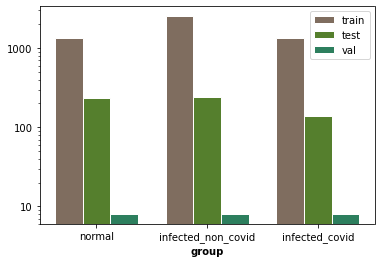

In [13]:
ld_train_counts = list(ld_train_a.dataset_numbers.values())
ld_test_counts = list(ld_test_a.dataset_numbers.values())
ld_val_counts = list(ld_val_a.dataset_numbers.values())

# set width of bars
barWidth = 0.25
 
# set heights of bars
bars1 = ld_train_counts
bars2 = ld_test_counts
bars3 = ld_val_counts
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='train')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='test')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='val')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['normal', 'infected_non_covid', 'infected_covid'])
 
# Create legend & Show graphic
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.legend()
plt.show()

In [14]:
#Initializing our dataloaders from different datasets
train_loader = DataLoader(ld_train_a, batch_size = 32, shuffle = True)
test_loader = DataLoader(ld_test_a, batch_size = 32, shuffle = True)
# val_loader = DataLoader(ld_val_a, batch_size = 24, shuffle = True)

In [15]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.block1 = self.conv_block(c_in=1, c_out=256, dropout=0.3, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.3, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.3, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=20, stride=1, padding=0)        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_layers = Sequential(
            Linear(648,2)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)        
        x = self.block2(x)        
        x = self.block3(x)
        x = self.maxpool(x)        
        x = self.lastcnn(x)  
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)      
        return x
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )        
        return seq_block

In [16]:
def multi_acc(predicted_output, ground_truth_label):
    predicted_output = torch.log_softmax(predicted_output, dim = 1)
    _, predicted_output = torch.max(predicted_output, dim = 1) 
    correct_pred = (predicted_output == ground_truth_label).float()
    acc = correct_pred.sum() / len(ground_truth_label)
    acc = torch.round(acc* 100) 
    return acc

def load_checkpoint(PATH):
    if os.path.isfile(PATH):
        print('Model checkpoint found, loading model...')
        checkpoint = torch.load(PATH)        
        return checkpoint
    else:
        print('No checkpoint found')
        return 

def save_checkpoint(epoch, PATH, loss_stats, accuracy_stats):
    # SAVE MODEL CHECKPOINT
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_stats': loss_stats,
        'accuracy_stats': accuracy_stats
    }, PATH)

# Training Loop
Preferably an 8GB GPU to run the model on jupyter notebook

In [17]:
device = "cpu"
model = Net2()
optimizer = optim.SGD(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss()

# Check if Cuda is available
if torch.cuda.is_available():
    device = "cuda"
    model = model.to(device)
    criterion = criterion.to(device)

# Define the dictionary used to store accuracy and loss values
accuracy_stats_a = {
    'train': [],
    "val": []
}
loss_stats_a = {
    'train': [],
    "val": []
}

# define start and end epoch
start_epoch = 0
num_epochs = 30

# attempts to load a checkpoint, if it doesn't exist it will return null
checkpoint = load_checkpoint("binary_model_A.pt")

# if the checkpoint exist then we load in all the values saved
if checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        loss_stats_a = checkpoint['loss_stats']
        accuracy_stats_a = checkpoint['accuracy_stats']
        
# Check if resuming training or training from scratch depending if model is found or not
if start_epoch != 0:
    print('Resuming Training from epoch: {}'.format(start_epoch+1))
else:
    print('Beginning Training from scratch...')

for e in range(start_epoch+1, num_epochs+1):    
    print('-' * 10)
    print('Epoch {}/{}'.format(e, num_epochs))
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for batch_idx, (inputs,labels) in enumerate(train_loader):
        train_inputs = inputs.to(device)
        train_labels = labels.to(device)
        optimizer.zero_grad()
        train_outputs = model(train_inputs)  
        # print(train_outputs)
        # train_loss = criterion(train_labels, train_outputs.long())
        train_loss = criterion(train_outputs, torch.max(train_labels,1)[1])
        # train_loss.requires_grad = True
        train_acc = multi_acc(train_outputs, torch.max(train_labels,1)[1])
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for batch_idx, (inputs,labels) in enumerate(test_loader):
            val_inputs = inputs.to(device)
            val_labels = labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, torch.max(val_labels,1)[1])
            val_acc = multi_acc(val_outputs, torch.max(val_labels,1)[1])
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats_a['train'].append(train_epoch_loss/len(train_loader))
    loss_stats_a['val'].append(val_epoch_loss/len(test_loader))
    accuracy_stats_a['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats_a['val'].append(val_epoch_acc/len(test_loader))
    print(f'Epoch {e}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(test_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(test_loader):.3f}')
    
    save_checkpoint(e, 'binary_model_A.pt', loss_stats_a, accuracy_stats_a)

print("Training Completed. Saving final binary_model_A...")
torch.save(model, "final_binary_model_A.pt")

No checkpoint found
Beginning Training from scratch...
----------
Epoch 1/30
Epoch 1: | Train Loss: 0.58038 | Val Loss: 0.63545 | Train Acc: 73.153| Val Acc: 60.050
----------
Epoch 2/30
Epoch 2: | Train Loss: 0.49923 | Val Loss: 0.57093 | Train Acc: 77.037| Val Acc: 63.650
----------
Epoch 3/30
Epoch 3: | Train Loss: 0.43679 | Val Loss: 0.54053 | Train Acc: 80.613| Val Acc: 66.650
----------
Epoch 4/30
Epoch 4: | Train Loss: 0.40168 | Val Loss: 0.53470 | Train Acc: 83.190| Val Acc: 68.400
----------
Epoch 5/30
Epoch 5: | Train Loss: 0.36836 | Val Loss: 0.49529 | Train Acc: 85.276| Val Acc: 71.850
----------
Epoch 6/30
Epoch 6: | Train Loss: 0.33790 | Val Loss: 0.46632 | Train Acc: 86.589| Val Acc: 75.550
----------
Epoch 7/30
Epoch 7: | Train Loss: 0.32390 | Val Loss: 0.45586 | Train Acc: 86.847| Val Acc: 76.450
----------
Epoch 8/30
Epoch 8: | Train Loss: 0.30236 | Val Loss: 0.44216 | Train Acc: 88.405| Val Acc: 77.150
----------
Epoch 9/30
Epoch 9: | Train Loss: 0.28619 | Val Loss: 

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Visualizing Train-Val Loss and Accuracy


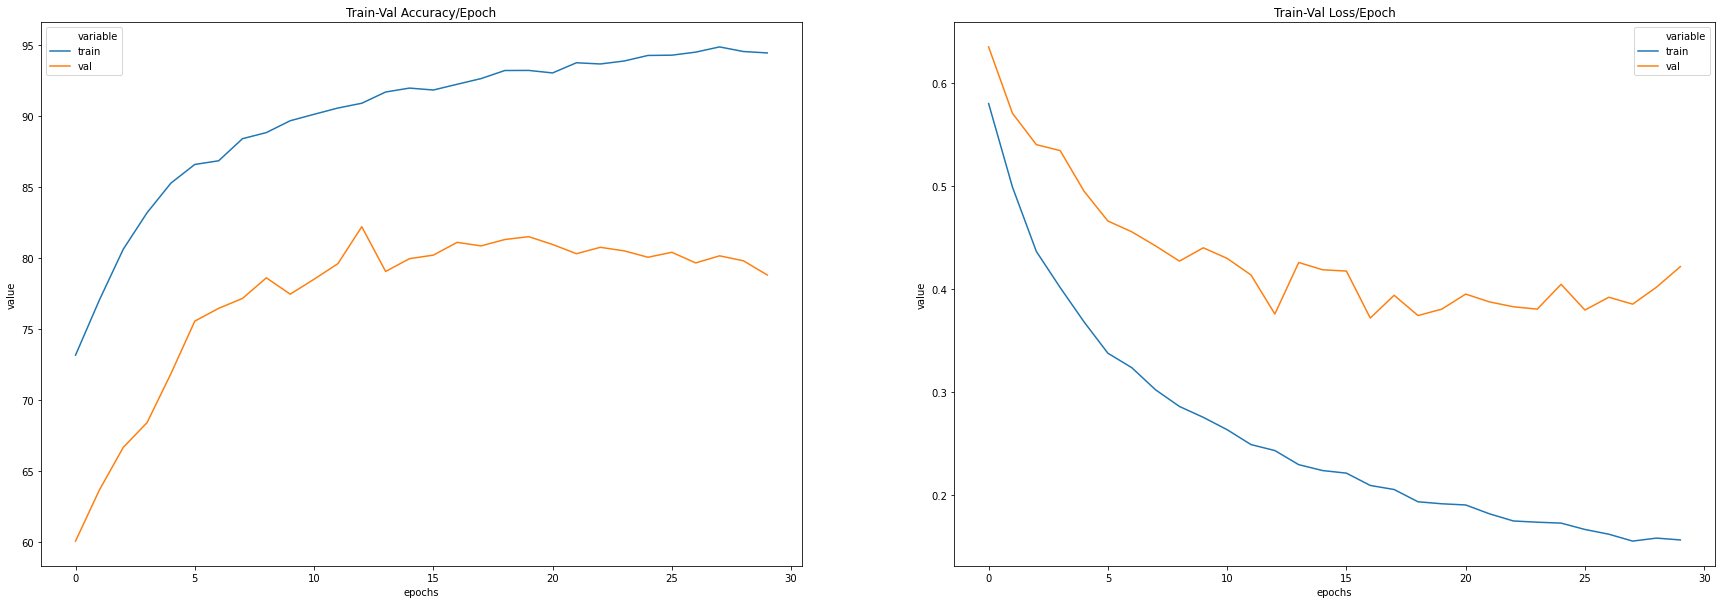

In [18]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_a).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_a).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')


# Saving the figure
fig.savefig("train-val-loss-accuracy-plot-model-A-BINARY.png")

# Classifying (Covid vs Non-covid)

In [19]:
class Lung_Train_Dataset_B(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles the important parameters in attrributes
        
        """
        
        #  All images are of size 150x150
        self.img_size = (150, 150)
        
        # Instead of two classes like the mock data we have three classes here to consider(normal, infected-covid, infected-non-covoid)
        self.classes = {0:'infected_non_covid', 1:'infected_covid'}
        
        # This dataset consists only of training images
        self.groups = 'train'
        
        self.dataset_numbers = {'train_infected_non_covid': 2530,\
                                'train_infected_covid':1345}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_infected_covid': './dataset/train/infected/covid/',\
                              'train_infected_non_covid': './dataset/train/infected/non-covid/'}
    

    def open_img(self, group_val, class_val, index_val): 
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
        
    def show_img(self, group_val, class_val, index_val):
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
    def __len__(self):
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])

        if index < first_val:
            class_val = 'infected_non_covid'
            label = torch.Tensor([1, 0])
        else:
            class_val = "infected_covid"
            index = index - (first_val)
            label = torch.Tensor([0, 1])
            
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        t = transforms.Normalize([0.5],[0.5])
        t(im)
        return im, label


In [36]:
class Lung_Test_Dataset_B(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles the important parameters in attrributes
        
        """
        
        #  All images are of size 150x150
        self.img_size = (150, 150)
        
        # Instead of two classes like the mock data we have three classes here to consider(normal, infected-covid, infected-non-covoid)
        self.classes = {0:'infected_non_covid', 1:'infected_covid'}
        
        # This dataset consists only of testing images
        self.groups = 'test'
        
        self.dataset_numbers = {
                                'test_infected_non_covid': 242,\
                                'test_infected_covid':138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {
                 'test_infected_covid': './dataset/test/infected/covid/',\
                 'test_infected_non_covid': './dataset/test/infected/non-covid/'}
    
        
    def open_img(self, group_val, class_val, index_val):

        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
        
    def show_img(self, group_val, class_val, index_val):

        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
    def __len__(self):

        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):

        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        if index < first_val:
            class_val = 'infected_non_covid'
            label = torch.Tensor([1, 0])
        else:
            class_val = "infected_covid"
            index = index - (first_val)
            label = torch.Tensor([0, 1])
            
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
#         t = transforms.Normalize([0.5],[0.5])
#         t(im)
        return im, label


In [37]:
ld_train_b = Lung_Train_Dataset_B()
ld_test_b = Lung_Test_Dataset_B()

In [38]:
#Initializing our dataloaders from different datasets
train_loaderb = DataLoader(ld_train_b, batch_size = 32, shuffle = True)
test_loaderb = DataLoader(ld_test_b, batch_size = 32, shuffle = True)


In [39]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.block1 = self.conv_block(c_in=1, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=20, stride=1, padding=0)        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_layers = Sequential(
            Linear(6272,2)
        )
    
    def forward(self, x):
        x = self.block1(x)
        # x = self.maxpool(x) removed one pooling layer for model to capture more details to differentiate between covid and non-covid      
        x = self.block2(x)        
        x = self.block3(x)
        x = self.maxpool(x)        
        x = self.lastcnn(x)  
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)      
        return x
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )        
        return seq_block

In [40]:
# We first initialize a brand new model from our architecture
device = "cpu"
model = Net3()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Check if Cuda is available
if torch.cuda.is_available():
    device = "cuda"
    model = model.to(device)
    criterion = criterion.to(device)
    
# Define the dictionary used to store accuracy and loss values
accuracy_stats_b = {
    'train': [],
    "val": []
}
loss_stats_b = {
    'train': [],
    "val": []
}

# define start and end epoch
start_epoch = 0
num_epochs = 50

# attempts to load a checkpoint, if it doesn't exist it will return null
checkpoint = load_checkpoint("binary_model_B.pt")

# if the checkpoint exist then we load in all the values saved
if checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        loss_stats_b = checkpoint['loss_stats']
        accuracy_stats_b = checkpoint['accuracy_stats']
        
# Check if resuming training or training from scratch depending if model is found or not
if start_epoch != 0:
    print('Resuming Training from epoch: {}'.format(start_epoch+1))
else:
    print('Beginning Training from scratch...')
        
for e in range(start_epoch+1, num_epochs+1):    
    print('-' * 10)
    print('Epoch {}/{}'.format(e, num_epochs))
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for batch_idx, (inputs,labels) in enumerate(train_loaderb):
        train_inputs = inputs.to(device)
        train_labels = labels.to(device)
        optimizer.zero_grad()
        train_outputs = model(train_inputs)      
        train_loss = criterion(train_outputs, torch.max(train_labels,1)[1])
        train_acc = multi_acc(train_outputs, torch.max(train_labels,1)[1])
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for batch_idx, (inputs,labels) in enumerate(test_loaderb):
            val_inputs = inputs.to(device)
            val_labels = labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, torch.max(val_labels,1)[1])
            val_acc = multi_acc(val_outputs, torch.max(val_labels,1)[1])
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats_b['train'].append(train_epoch_loss/len(train_loaderb))
    loss_stats_b['val'].append(val_epoch_loss/len(test_loaderb))
    accuracy_stats_b['train'].append(train_epoch_acc/len(train_loaderb))
    accuracy_stats_b['val'].append(val_epoch_acc/len(test_loaderb))
    print(f'Epoch {e}: | Train Loss: {train_epoch_loss/len(train_loaderb):.5f} | Val Loss: {val_epoch_loss/len(test_loaderb):.5f} | Train Acc: {train_epoch_acc/len(train_loaderb):.3f}| Val Acc: {val_epoch_acc/len(test_loaderb):.3f}')
    
    save_checkpoint(e, 'binary_model_B.pt', loss_stats_b, accuracy_stats_b)

print("Training Completed. Saving final binary_model_B...")
torch.save(model, "final_binary_model_B.pt")

No checkpoint found
Beginning Training from scratch...
----------
Epoch 1/50
Epoch 1: | Train Loss: 0.63906 | Val Loss: 0.57944 | Train Acc: 65.459| Val Acc: 81.750
----------
Epoch 2/50
Epoch 2: | Train Loss: 0.59927 | Val Loss: 0.50673 | Train Acc: 69.689| Val Acc: 77.083
----------
Epoch 3/50
Epoch 3: | Train Loss: 0.57312 | Val Loss: 0.46488 | Train Acc: 72.377| Val Acc: 80.000
----------
Epoch 4/50
Epoch 4: | Train Loss: 0.56740 | Val Loss: 0.43812 | Train Acc: 73.787| Val Acc: 86.250
----------
Epoch 5/50
Epoch 5: | Train Loss: 0.56016 | Val Loss: 0.42788 | Train Acc: 74.270| Val Acc: 85.250
----------
Epoch 6/50
Epoch 6: | Train Loss: 0.54989 | Val Loss: 0.41181 | Train Acc: 74.607| Val Acc: 86.750
----------
Epoch 7/50
Epoch 7: | Train Loss: 0.54645 | Val Loss: 0.41123 | Train Acc: 75.090| Val Acc: 86.500
----------
Epoch 8/50
Epoch 8: | Train Loss: 0.53999 | Val Loss: 0.39630 | Train Acc: 74.902| Val Acc: 86.833
----------
Epoch 9/50
Epoch 9: | Train Loss: 0.54375 | Val Loss: 

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


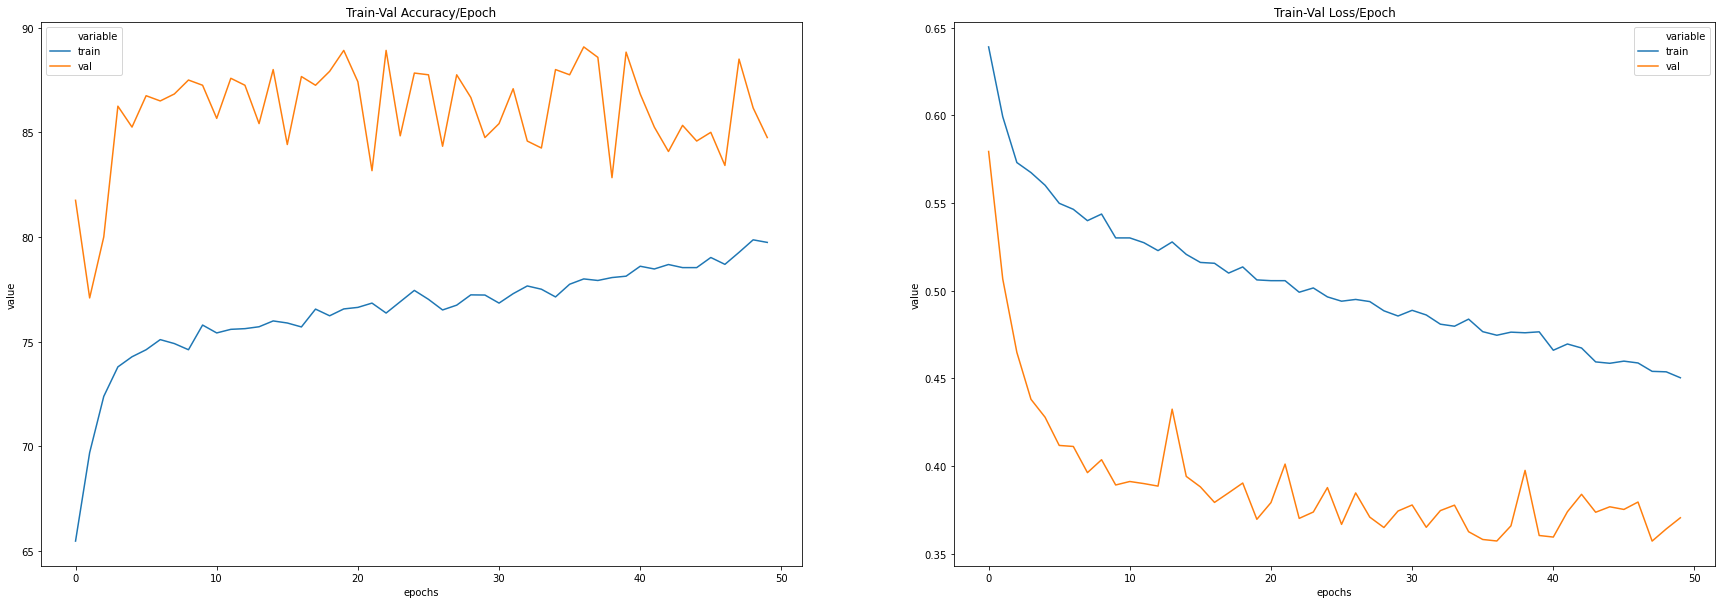

In [41]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_b).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_b).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')


# Saving the figure
fig.savefig("train-val-loss-accuracy-plot-model-B-BINARY.png")

# Predicting on Test Set


In [42]:
class Lung_Val_Dataset_B(Dataset):
    
    def __init__(self):

        self.img_size = (150, 150)
        
        self.classes = {0:'normal', 1:'infected_non_covid', 2:'infected_covid'}
        
        self.groups = 'val'
        
        self.dataset_numbers = {'val_normal':8,\
                                'val_infected_non_covid': 8,\
                                'val_infected_covid':8}

        self.dataset_paths = {'val_normal': './dataset/val/normal/',\
                 'val_infected_covid': './dataset/val/infected/covid/',\
                 'val_infected_non_covid': './dataset/val/infected/non-covid/'}
    

        
    def open_img(self, group_val, class_val, index_val):
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
        
    def show_img(self, group_val, class_val, index_val):
        im = self.open_img(group_val, class_val, index_val)
        plt.imshow(im)
        
    def __len__(self):
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index < (first_val+second_val):
            class_val = 'infected_non_covid'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = "infected_covid"
            index = index - (first_val+second_val)
            label = torch.Tensor([0, 0, 1])
            
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
#         t = transforms.Normalize([0.5],[0.5])
#         t(im)
        return im, label
    
# This final val dataset will have a multi-class __getitem__ function so that we can perform our comparison later and retrieve
# the labels easily for each of the images after prediction

In [43]:
# Instantiate dataset class and dataloader (batch_size doesn't matter, we just pass all 24 images when predicting)
ld_val_b = Lung_Val_Dataset_B()
val_loaderb = DataLoader(ld_val_b, batch_size = 24, shuffle = True)

[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
final predictions: [2 1 2 2 0 0 0 2 1 2 2 1 1 2 2 2 1 1 2 2 2 1 1 2]
ground truths: [1 2 0 2 0 0 0 2 1 1 0 0 1 2 2 2 0 1 1 2 0 1 2 1]
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.50      0.50      0.50         8
           2       0.46      0.75      0.57         8

    accuracy                           0.54        24
   macro avg       0.65      0.54      0.54        24
weighted avg       0.65      0.54      0.54        24



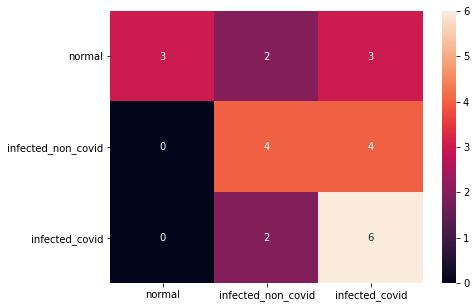

In [47]:
from itertools import chain 

# Check if Cuda is available
# path. We can skip this if just running the whole notebook as a whole

trained_model_A = torch.load('final_binary_model_A.pt') # classifies between infected and normal
trained_model_B = torch.load('final_binary_model_B.pt') # classifies between covid and non-covid


# Loading the pre-trained saved model from 
test_outputs_list = []
test_labels_list = []
with torch.no_grad():

    for inputs,labels in (val_loaderb):
        test_inputs, test_labels = inputs.to(device), labels.to(device)
        test_outputs = trained_model_A(test_inputs)

        _, test_outputs = torch.max(test_outputs, dim = 1)
        test_outputs_list = test_outputs.cpu().numpy()
        x = torch.tensor(1)
        idx = (test_outputs == x).nonzero().flatten()
        list_of_infected = (idx.tolist())
        infected_inputs = []
        for i in list_of_infected:
            infected_inputs.append(test_inputs[i])
        print(list_of_infected)
        infected_inputs_tensor = torch.stack(infected_inputs, dim=0)
        infected_test_outputs = trained_model_B(infected_inputs_tensor)
        _, infected_test_outputs = torch.max(infected_test_outputs, dim=1)
        infected_test_outputs = infected_test_outputs.cpu().numpy()
        
        index = 0
        for e in list_of_infected:
            # if the predicted is infected_covid we change the label to 2
            # else we can leave it as 1
            if infected_test_outputs[index] == 1:
                test_outputs_list[e] = 2
            index += 1
        print("final predictions:", test_outputs_list)
        test_labels_list = torch.max(test_labels,1)[1].cpu().numpy()
        print("ground truths:", test_labels_list)


# report is only used for extracting total accuracy later (don't print)
report = classification_report(test_labels_list, test_outputs_list, output_dict=True)

print(classification_report(test_labels_list, test_outputs_list))
#Creating a data-frame from confusion matrix and plot it as a heat-map using seaborn library
classes = {0:'normal', 1:'infected_non_covid', 2:'infected_covid'}
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_labels_list, test_outputs_list)).rename(columns=classes, index=classes)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
#Ground Truth is the vertical column

# Visualizing our predictions
can't plot this in google colab, need to run in jupyter notebook

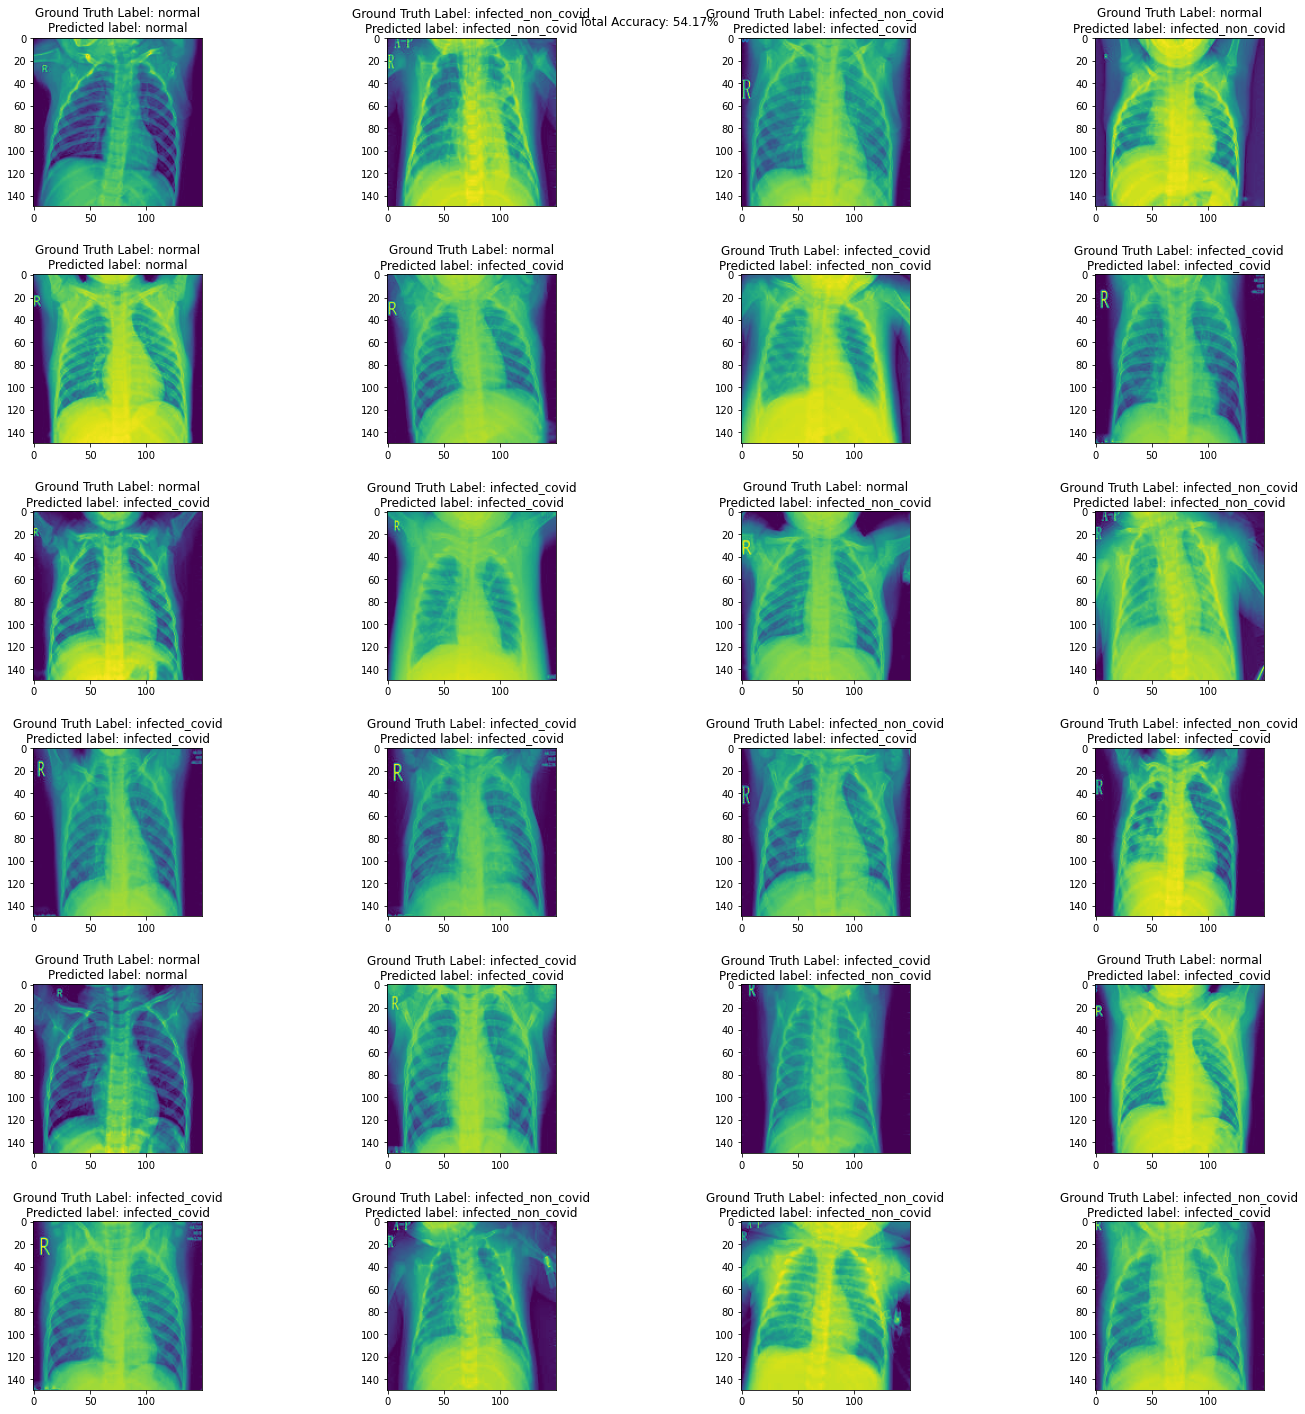

In [45]:
import numpy as np
import matplotlib.pyplot as plt

w = 50
h = 50
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 6

# prep (x,y) for extra plotting
xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
ys = np.abs(np.sin(xs))           # absolute of sine

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    image_data = test_inputs[i]
    img = image_data.reshape(150,150).cpu().numpy()
    
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("Ground Truth Label: " + ld_val_b.classes.get(test_labels_list[i]) # set ground truth label
                    +'\n'+ 'Predicted label: '+ ld_val_b.classes.get(test_outputs_list[i])) # set predicted label

    plt.imshow(img, alpha=1)


# do extra plots on selected axes/subplots
# note: index starts with 0
ax[2].plot(xs, 3*ys)
ax[19].plot(ys**2, xs)
title = "Total Accuracy: " + "{:.2f}".format(report["accuracy"]*100) +"%"
fig.suptitle(title)
plt.tight_layout(pad=2)
plt.show()  # finally, render the plot